In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
from numpy.ma import masked_array
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import os
import glob
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib import rc
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
import iminuit
from math import *
from iminuit import Minuit, describe, Struct
MetalFlag=0
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
path = "/data/MochimaMulti_SGP/Mo_SF0_Delayed_Iso/output_00161"

#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
SF1ME = wkbl.Galaxy_Hound(path,virial=True)
nucenter = nbe.real_center(SF1ME.st.pos3d, SF1ME.st.mass)
SF1ME.center_shift(nucenter)
SF1ME.r_virial(600)
ok,SF1ME.st.rho,_= CF.getDensity(np.array(SF1ME.st.pos3d.reshape(len(SF1ME.st.pos3d)*3),
                                           dtype=np.float32), SF1ME.st.mass)

loading Dark matter..
loading Stars..
loading Gas..
| r_200 = 65.04
| Diagonal matrix computed 
|    | 15, 0, 0|
| D =| 0, 14, 0|
|    | 0,  0, 3|


In [4]:
def dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0):
    dadtau = axp_tau*axp_tau*axp_tau *( O_mat_0 + O_vac_0 * axp_tau*axp_tau*axp_tau + O_k_0*axp_tau )
    dadtau = sqrt(dadtau)
    return dadtau

def dadt(axp_t,O_mat_0,O_vac_0,O_k_0):
    dadt   = (1.0/axp_t)* ( O_mat_0 + O_vac_0*axp_t*axp_t*axp_t + O_k_0*axp_t )
    dadt = sqrt(dadt)
    return dadt



def friedman(O_mat_0,O_vac_0,O_k_0,alpha,axp_min,ntable,myaexp):
    axp_tau = myaexp
    axp_t = myaexp
    tau = 0.0
    t = 0.0
    nstep = 0

    while axp_tau >= axp_min and axp_t >= axp_min:
       nstep = nstep + 1

       dtau = alpha * axp_tau / dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)
       axp_tau_pre = axp_tau - dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)*dtau/2.
       axp_tau = axp_tau - dadtau(axp_tau_pre,O_mat_0,O_vac_0,O_k_0)*dtau
       tau = tau - dtau

       dt = alpha * axp_t / dadt(axp_t,O_mat_0,O_vac_0,O_k_0)
       axp_t_pre = axp_t - dadt(axp_t,O_mat_0,O_vac_0,O_k_0)*dt/2.
       axp_t = axp_t - dadt(axp_t_pre,O_mat_0,O_vac_0,O_k_0)*dt
       t = t - dt
    age_tot=-t
    print(' Age of the Universe (in unit of 1/H0)= ',-t)

    nskip=floor(nstep/ntable)

    axp_t = myaexp
    t = 0.0
    axp_tau = myaexp
    tau = 0.
    nstep =0
    nout=0
    t_out=np.array([t])
    tau_out=np.array([tau])
    axp_out=np.array([axp_tau])
    hexp_out=np.array([dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)/axp_tau])

    while axp_tau >= axp_min and axp_t >= axp_min:
        nstep = nstep + 1
        dtau = alpha * axp_tau / dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)
        axp_tau_pre = axp_tau - dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)*dtau/2.
        axp_tau = axp_tau - dadtau(axp_tau_pre,O_mat_0,O_vac_0,O_k_0)*dtau
        tau = tau - dtau

        dt = alpha * axp_t / dadt(axp_t,O_mat_0,O_vac_0,O_k_0)
        axp_t_pre = axp_t - dadt(axp_t,O_mat_0,O_vac_0,O_k_0)*dt/2.
        axp_t = axp_t - dadt(axp_t_pre,O_mat_0,O_vac_0,O_k_0)*dt
        t = t - dt

        if fmod(nstep,nskip) ==0:
            nout=nout+1
            t_out=np.append([t_out],[t])
            tau_out=np.append([tau_out],[tau])
            axp_out=np.append([axp_out],[axp_tau])
            hexp_out=np.append([hexp_out],[dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)/axp_tau])
    #print("nout= ",nout)
    #print("t_out= ",t_out," ",len(t_out))
    t_out=np.append([t_out],[t])
    tau_out=np.append([tau_out],[tau])
    axp_out=np.append([axp_out],[axp_tau])
    hexp_out=np.append([hexp_out],[dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)/axp_tau])
    #print("t_out2= ",t_out," ",len(t_out))
    #t_out[ntable]=t
    #tau_out[ntable]=tau
    #axp_out[ntable]=axp_tau
    #hexp_out[ntable]=dadtau(axp_tau,O_mat_0,O_vac_0,O_k_0)/axp_tau

    return t_out, tau_out, axp_out, hexp_out, age_tot

In [5]:
n_frw=1e3
t_frw,tau_frw,aexp_frw,hexp_frw,time_tot=friedman(SF1ME.p._vars["omega_m"],SF1ME.p._vars["omega_l"],
                                                  SF1ME.p._vars["omega_k"],1e-6,1e-3,n_frw,SF1ME.p.aexp)


(' Age of the Universe (in unit of 1/H0)= ', 0.2913008511777399)


In [29]:
i=1
while tau_frw[i]>t and i<n_frw:
    i+=1
print n_frw

1000.0


In [17]:
def get_it(sim):
    minn, maxx = sim.st.age.min(), sim.st.age.max()
    condition = (sim.st.r<0.2*sim.r200)
    bins = np.int(np.abs(np.int((minn-maxx)/0.04)))
    age_hist = np.histogram((sim.st.age[condition]) / SF1ME.p.aexp**2 ,bins=bins,weights=sim.st.mass[condition])
    return age_hist

<IPython.core.display.Javascript object>


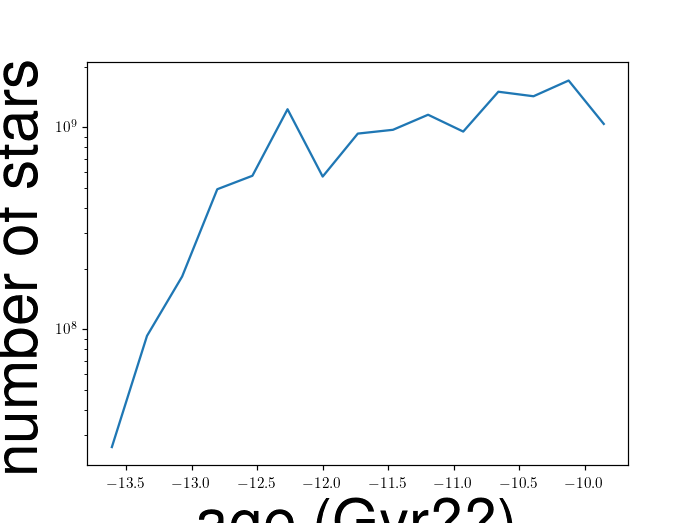

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("age (Gyr??)",fontsize=40)
ax.set_ylabel("number of stars",fontsize=40)

ax.set_yscale('log')
age_hist = get_it(SF1ME)
t = age_hist[1][1]-age_hist[1][0]
ax.plot(age_hist[1][:-1],age_hist[0])